In [215]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_tables.gen_pair_configs as gen_pair
import data.scripts.predict.predict_slowdown as predict

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Pair - dynamic

In [455]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
intra_pkl = os.path.join(PKL_PATH, 'intra.pkl')
csv = os.path.join(HOME, 'data/csv/pair_dynamic.csv')
output = os.path.join(PKL_PATH, 'pair_dynamic_seq.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --intra_pkl $intra_pkl 

In [456]:
df_dynamic = pd.read_pickle(output)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)
print(df_dynamic.shape)

# FIXME: drop any rows with zero fairness
df_dynamic = df_dynamic[df_dynamic['fairness'] > 0]
print(df_dynamic.shape)


(561, 211)
(561, 211)


# Prediction Model

In [469]:
X, y = predict.prepare_datasets(df_dynamic, cc=False)
model = predict.train(X, y)

X invalid? False
y invalid? False
X invalid? False
y invalid? False
(1122, 6) (1122,)
K-fold l1 error: 0.03367208348448414
K-fold l1 error: 0.027357847720927208
K-fold l1 error: 0.03194331961063289
K-fold l1 error: 0.029630522557813392
K-fold l1 error: 0.029284918984625263


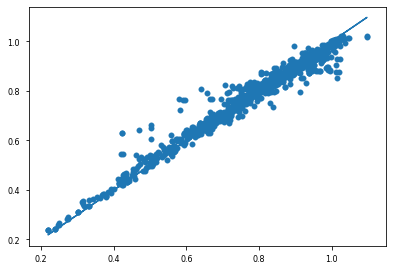

In [470]:
plt.scatter(y, model.predict(X))
plt.plot(y, y)
plt.show()

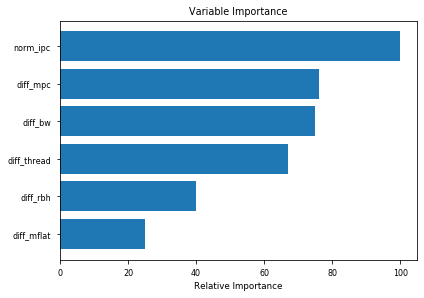

In [471]:
predict.plot_importance(model)

In [472]:
df_dynamic['1_predicted'] = predict.predict_from_df(model, df_dynamic, 'x')
df_dynamic['2_predicted'] = predict.predict_from_df(model, df_dynamic, 'y')

df_dynamic['1_delta'] = df_dynamic['1_predicted'] - df_dynamic['1_sld']
df_dynamic['2_delta'] = df_dynamic['2_predicted'] - df_dynamic['2_sld']

In [474]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_seq = ['1_bench', 'intra_x', 'l2_x',
                   '2_bench', 'intra_y', 'l2_y',
#                    'norm_ipc_x', 
                   '1_sld', '1_predicted',  #'1_infer', 
                   '1_delta',
#                    'diff_rbh_x', 'diff_mflat_x', 'diff_bw_x', 'diff_mpc_x', 'diff_thread_x', 'l2_miss_rate_x',
#                    'norm_ipc_y', 
                   '2_sld', '2_predicted',  #'2_infer', 
                   '2_delta',
                   'ws', 'fairness', 
#                    'sum_ipc', 'diff_mflat', 'sum_dram',
#                    '1_norm_mflat', '2_norm_mflat'
                  ]
def highlight_error(s):
    is_high = np.abs(s) > 0.1
    return ['background-color: yellow' if v else '' for v in is_high]

draw_table(df_dynamic_show, 
           col_dynamic_seq).apply(highlight_error, subset=['1_delta', '2_delta'])

1_bench,intra_x,l2_x,2_bench,intra_y,l2_y,1_sld,1_predicted,1_delta,2_sld,2_predicted,2_delta,ws,fairness
parb_cutcp-0,2,0.25,rod_heartwall-0,1,0.75,0.987002,0.894532,-0.0924704,1.02168,0.982177,-0.0395074,2.00869,0.966054
parb_cutcp-0,2,0.25,parb_stencil-0,7,0.75,0.904176,0.901452,-0.00272386,1.09725,1.02108,-0.0761709,2.00143,0.824035
parb_cutcp-0,2,0.25,parb_spmv-0,6,0.75,0.9668,0.945051,-0.0217486,1.03307,1.00917,-0.023894,1.99987,0.935853
cut_wmma-0,2,0.75,parb_cutcp-0,2,0.25,0.970845,0.913319,-0.0575264,0.950564,0.904538,-0.0460258,1.92141,0.97911
cut_sgemm-1,1,0.5,parb_spmv-0,7,0.5,0.956757,0.943643,-0.0131141,0.927708,0.909945,-0.0177628,1.88446,0.969638
parb_cutcp-0,2,0.25,parb_lbm-0,1,0.75,0.954269,0.929901,-0.0243676,0.929749,0.920516,-0.00923265,1.88402,0.974305
parb_cutcp-0,2,0.25,rod_hotspot3d-0,4,0.75,0.934001,0.9308,-0.00320116,0.904509,0.900814,-0.00369526,1.83851,0.968425
cut_sgemm-1,1,0.25,rod_heartwall-0,1,0.75,0.998312,0.936715,-0.0615978,0.837806,0.850192,0.0123852,1.83612,0.839223
cut_wmma-0,2,0.75,rod_heartwall-0,1,0.25,0.95321,0.883867,-0.0693434,0.847453,0.831437,-0.0160161,1.80066,0.889052
cut_sgemm-1,1,0.25,cut_wmma-0,2,0.75,0.937581,0.871333,-0.066248,0.850349,0.830952,-0.0193973,1.78793,0.906961
